In [1]:
import torch
from torch import nn
from torch.optim import Adam, Optimizer
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

from mil_autoencoder.model.vae import VAE
from mil_autoencoder.data.loader import load_data, create_loaders
from mil_autoencoder.data.transformers import simple_transform
from mil_autoencoder.paths import DATA, TRAINED_MODELS

%matplotlib inline

# Model

In [2]:
import typing as tp
from pathlib import Path

class ClassificationHead(nn.Module):
    def __init__(self, encoder: nn.Module, latent_size: int, start_dim: int = 32) -> None:
        super().__init__()
        
        self.encoder = encoder
        self.encoder.requires_grad_(False)
        self.num_of_classes = 10
        self.head = self.build_head(latent_size, start_dim)
    
    def build_head(self, latent_size: int, start_size: int = 32) -> nn.Module:
        modules = []
        dims = [start_size]
        start_pow = len(f"{start_size - 1:b}") - 1
        dims.extend([2 ** i for i in range(start_pow, 3, -1)])
        prev_dim = latent_size

        for dim in dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(prev_dim, dim),
                    nn.BatchNorm1d(dim),
                    nn.ReLU(),
                ),
            )
            prev_dim = dim
        
        modules.append(nn.Linear(prev_dim, self.num_of_classes))
        return nn.Sequential(*modules)

    def forward(self, img: torch.Tensor):
        latent_repr, _ = self.encoder(img)
        return self.head(latent_repr)
    
    def unfreeze_encoder(self):
        self.encoder.requires_grad_(True)

In [10]:
vae_path = TRAINED_MODELS / "smaller_vae_state_dict50"
vae_params = {
    "img_size": 32,
    "downsamplings": 3,
    "latent_size": 64,
    "linear_hidden_size": 128,
    "down_channels": 4,
    "up_channels": 4,
}

vae = VAE(**vae_params)
vae.load_state_dict(torch.load(vae_path, map_location=torch.device('cpu')))

model = ClassificationHead(encoder=vae.encoder, latent_size=vae_params["latent_size"])

# Train

In [3]:
from sklearn.metrics import classification_report
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
trainset, testset, classes = load_data(DATA, simple_transform(), simple_transform())
trainloader, testloader = create_loaders(
    trainset,
    testset,
    train_batch=32,
    test_batch=32,
)

Files already downloaded and verified
Files already downloaded and verified


In [57]:
def train(
    model: nn.Module,
    optim: Optimizer,
    loss_func: tp.Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    epochs: int,
    trainloader: DataLoader,
    testloader: DataLoader,
    labels: tp.Set[str], 
    device: torch.device):
    
    train_loss_history = []
    test_loss_hitory = []

    model.to(device)

    for ep in range(1, epochs + 1):
        avg_loss = 0
        total_batches = 0

        model.train()
        for imgs, target in tqdm(trainloader, desc=f"Train #{ep}"):
            total_batches += 1
            imgs.to(device)
            preds = model(imgs)
            loss = loss_func(preds, target)
            optim.zero_grad()
            loss.backward()
            optim.step()
            avg_loss += loss.item()
        
        avg_loss /= total_batches
        train_loss_history.append(avg_loss)
        print(f"Epoch #{ep} | Train Avg Loss: {avg_loss:.4f} ")

        model.eval()
        with torch.no_grad():
            avg_loss = 0
            total_batches = 0
            preds_labels = np.array([])
            target_labels = np.array([])
            for imgs, target in tqdm(testloader, desc=f"Test #{ep}"):
                total_batches += 1
                imgs.to(device)
                preds = model(imgs)
                avg_loss += loss_func(preds, target).item()
                preds = preds.detach().cpu().numpy()
                batch_pred_labels = preds.argmax(axis=1)
                preds_labels = np.concatenate((preds_labels, batch_pred_labels))
                target_labels = np.concatenate((target_labels, target.detach().numpy()))
            
            avg_loss /= total_batches
            test_loss_hitory.append(avg_loss)
            print(f"Epoch #{ep} | Test Avg Loss: {avg_loss:.4f} ")
            print(classification_report(target_labels.astype(int), preds_labels.astype(int), target_names=labels))
    
    return train_loss_history, test_loss_hitory

## Small Model

In [58]:
vae_path = TRAINED_MODELS / "smaller_vae_state_dict50"
vae_params = {
    "img_size": 32,
    "downsamplings": 3,
    "latent_size": 64,
    "linear_hidden_size": 128,
    "down_channels": 4,
    "up_channels": 4,
}

vae = VAE(**vae_params)
vae.load_state_dict(torch.load(vae_path, map_location=torch.device('cpu')))

model = ClassificationHead(encoder=vae.encoder, latent_size=vae_params["latent_size"])
optim = Adam(model.parameters())
loss_function = nn.CrossEntropyLoss()


In [59]:
train_loss, test_loss = train(
    model,
    optim,
    loss_function,
    epochs=25,
    device=device,
    trainloader=trainloader,
    testloader=testloader,
    labels=classes
)

Train #1: 100%|██████████| 1563/1563 [00:54<00:00, 28.61it/s]


Epoch #1 | Train Avg Loss: 1.8915 


Test #1: 100%|██████████| 313/313 [00:07<00:00, 43.25it/s]


Epoch #1 | Test Avg Loss: 1.6740 
              precision    recall  f1-score   support

       plane       0.46      0.52      0.49      1000
         car       0.48      0.54      0.51      1000
        bird       0.30      0.16      0.21      1000
         cat       0.29      0.15      0.20      1000
        deer       0.34      0.31      0.33      1000
         dog       0.37      0.35      0.36      1000
        frog       0.35      0.54      0.42      1000
       horse       0.41      0.42      0.42      1000
        ship       0.47      0.59      0.52      1000
       truck       0.47      0.47      0.47      1000

    accuracy                           0.41     10000
   macro avg       0.39      0.41      0.39     10000
weighted avg       0.39      0.41      0.39     10000



Train #2: 100%|██████████| 1563/1563 [00:46<00:00, 33.77it/s]


Epoch #2 | Train Avg Loss: 1.6743 


Test #2: 100%|██████████| 313/313 [00:06<00:00, 46.79it/s]


Epoch #2 | Test Avg Loss: 1.5945 
              precision    recall  f1-score   support

       plane       0.48      0.52      0.50      1000
         car       0.53      0.56      0.54      1000
        bird       0.28      0.17      0.22      1000
         cat       0.30      0.19      0.23      1000
        deer       0.35      0.37      0.36      1000
         dog       0.40      0.34      0.36      1000
        frog       0.37      0.56      0.44      1000
       horse       0.46      0.47      0.47      1000
        ship       0.52      0.59      0.56      1000
       truck       0.46      0.47      0.47      1000

    accuracy                           0.42     10000
   macro avg       0.41      0.42      0.41     10000
weighted avg       0.41      0.42      0.41     10000



Train #3: 100%|██████████| 1563/1563 [00:41<00:00, 37.82it/s]


Epoch #3 | Train Avg Loss: 1.6161 


Test #3: 100%|██████████| 313/313 [00:08<00:00, 37.87it/s]


Epoch #3 | Test Avg Loss: 1.5558 
              precision    recall  f1-score   support

       plane       0.50      0.56      0.53      1000
         car       0.54      0.60      0.57      1000
        bird       0.31      0.25      0.28      1000
         cat       0.30      0.25      0.27      1000
        deer       0.36      0.36      0.36      1000
         dog       0.42      0.30      0.35      1000
        frog       0.39      0.62      0.48      1000
       horse       0.52      0.45      0.48      1000
        ship       0.56      0.60      0.58      1000
       truck       0.51      0.47      0.49      1000

    accuracy                           0.45     10000
   macro avg       0.44      0.45      0.44     10000
weighted avg       0.44      0.45      0.44     10000



Train #4: 100%|██████████| 1563/1563 [00:45<00:00, 34.15it/s]


Epoch #4 | Train Avg Loss: 1.5863 


Test #4: 100%|██████████| 313/313 [00:06<00:00, 50.85it/s]


Epoch #4 | Test Avg Loss: 1.5310 
              precision    recall  f1-score   support

       plane       0.55      0.52      0.53      1000
         car       0.54      0.60      0.57      1000
        bird       0.31      0.27      0.29      1000
         cat       0.30      0.21      0.24      1000
        deer       0.37      0.36      0.37      1000
         dog       0.40      0.39      0.39      1000
        frog       0.41      0.56      0.47      1000
       horse       0.53      0.45      0.49      1000
        ship       0.54      0.63      0.58      1000
       truck       0.50      0.52      0.51      1000

    accuracy                           0.45     10000
   macro avg       0.44      0.45      0.44     10000
weighted avg       0.44      0.45      0.44     10000



Train #5: 100%|██████████| 1563/1563 [00:52<00:00, 29.54it/s]


Epoch #5 | Train Avg Loss: 1.5662 


Test #5: 100%|██████████| 313/313 [00:14<00:00, 22.05it/s]


Epoch #5 | Test Avg Loss: 1.5201 
              precision    recall  f1-score   support

       plane       0.56      0.53      0.55      1000
         car       0.59      0.57      0.58      1000
        bird       0.34      0.22      0.27      1000
         cat       0.29      0.18      0.22      1000
        deer       0.36      0.41      0.39      1000
         dog       0.40      0.37      0.39      1000
        frog       0.38      0.62      0.48      1000
       horse       0.50      0.51      0.51      1000
        ship       0.58      0.61      0.59      1000
       truck       0.51      0.53      0.52      1000

    accuracy                           0.46     10000
   macro avg       0.45      0.46      0.45     10000
weighted avg       0.45      0.46      0.45     10000



Train #6: 100%|██████████| 1563/1563 [01:04<00:00, 24.27it/s]


Epoch #6 | Train Avg Loss: 1.5572 


Test #6: 100%|██████████| 313/313 [00:12<00:00, 25.31it/s]


Epoch #6 | Test Avg Loss: 1.5119 
              precision    recall  f1-score   support

       plane       0.55      0.55      0.55      1000
         car       0.57      0.56      0.57      1000
        bird       0.35      0.26      0.30      1000
         cat       0.34      0.12      0.18      1000
        deer       0.39      0.41      0.40      1000
         dog       0.37      0.41      0.39      1000
        frog       0.41      0.62      0.49      1000
       horse       0.49      0.52      0.50      1000
        ship       0.59      0.62      0.60      1000
       truck       0.50      0.54      0.52      1000

    accuracy                           0.46     10000
   macro avg       0.45      0.46      0.45     10000
weighted avg       0.45      0.46      0.45     10000



Train #7: 100%|██████████| 1563/1563 [01:47<00:00, 14.50it/s]


Epoch #7 | Train Avg Loss: 1.5434 


Test #7: 100%|██████████| 313/313 [00:08<00:00, 37.05it/s]


Epoch #7 | Test Avg Loss: 1.5037 
              precision    recall  f1-score   support

       plane       0.55      0.55      0.55      1000
         car       0.56      0.56      0.56      1000
        bird       0.35      0.24      0.29      1000
         cat       0.33      0.21      0.26      1000
        deer       0.36      0.45      0.40      1000
         dog       0.38      0.36      0.37      1000
        frog       0.43      0.57      0.49      1000
       horse       0.47      0.52      0.50      1000
        ship       0.56      0.64      0.59      1000
       truck       0.54      0.48      0.51      1000

    accuracy                           0.46     10000
   macro avg       0.45      0.46      0.45     10000
weighted avg       0.45      0.46      0.45     10000



Train #8: 100%|██████████| 1563/1563 [01:13<00:00, 21.28it/s]


Epoch #8 | Train Avg Loss: 1.5374 


Test #8: 100%|██████████| 313/313 [00:13<00:00, 23.44it/s]


Epoch #8 | Test Avg Loss: 1.4914 
              precision    recall  f1-score   support

       plane       0.55      0.53      0.54      1000
         car       0.58      0.57      0.58      1000
        bird       0.34      0.27      0.30      1000
         cat       0.33      0.23      0.27      1000
        deer       0.42      0.35      0.38      1000
         dog       0.38      0.37      0.38      1000
        frog       0.42      0.65      0.51      1000
       horse       0.48      0.54      0.51      1000
        ship       0.56      0.64      0.60      1000
       truck       0.53      0.51      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.46     10000
weighted avg       0.46      0.47      0.46     10000



Train #9: 100%|██████████| 1563/1563 [00:48<00:00, 32.41it/s]


Epoch #9 | Train Avg Loss: 1.5306 


Test #9: 100%|██████████| 313/313 [00:08<00:00, 38.40it/s]


Epoch #9 | Test Avg Loss: 1.4923 
              precision    recall  f1-score   support

       plane       0.54      0.54      0.54      1000
         car       0.58      0.58      0.58      1000
        bird       0.35      0.27      0.30      1000
         cat       0.33      0.19      0.24      1000
        deer       0.40      0.40      0.40      1000
         dog       0.39      0.41      0.40      1000
        frog       0.42      0.64      0.51      1000
       horse       0.49      0.53      0.51      1000
        ship       0.57      0.63      0.60      1000
       truck       0.55      0.48      0.51      1000

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.46     10000
weighted avg       0.46      0.47      0.46     10000



Train #10: 100%|██████████| 1563/1563 [00:48<00:00, 32.44it/s]


Epoch #10 | Train Avg Loss: 1.5267 


Test #10: 100%|██████████| 313/313 [00:06<00:00, 46.87it/s]


Epoch #10 | Test Avg Loss: 1.4859 
              precision    recall  f1-score   support

       plane       0.57      0.49      0.53      1000
         car       0.57      0.58      0.58      1000
        bird       0.32      0.33      0.33      1000
         cat       0.32      0.22      0.26      1000
        deer       0.42      0.32      0.36      1000
         dog       0.38      0.41      0.39      1000
        frog       0.45      0.60      0.51      1000
       horse       0.48      0.54      0.51      1000
        ship       0.60      0.60      0.60      1000
       truck       0.51      0.56      0.53      1000

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.46     10000
weighted avg       0.46      0.47      0.46     10000



Train #11: 100%|██████████| 1563/1563 [00:43<00:00, 35.84it/s]


Epoch #11 | Train Avg Loss: 1.5239 


Test #11: 100%|██████████| 313/313 [00:08<00:00, 36.79it/s]


Epoch #11 | Test Avg Loss: 1.4792 
              precision    recall  f1-score   support

       plane       0.54      0.55      0.54      1000
         car       0.56      0.61      0.59      1000
        bird       0.34      0.28      0.31      1000
         cat       0.34      0.22      0.27      1000
        deer       0.41      0.40      0.40      1000
         dog       0.40      0.38      0.39      1000
        frog       0.45      0.60      0.51      1000
       horse       0.49      0.53      0.51      1000
        ship       0.57      0.64      0.60      1000
       truck       0.52      0.51      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.46     10000
weighted avg       0.46      0.47      0.46     10000



Train #12: 100%|██████████| 1563/1563 [00:46<00:00, 33.80it/s]


Epoch #12 | Train Avg Loss: 1.5191 


Test #12: 100%|██████████| 313/313 [00:08<00:00, 37.09it/s]


Epoch #12 | Test Avg Loss: 1.4818 
              precision    recall  f1-score   support

       plane       0.56      0.53      0.54      1000
         car       0.60      0.55      0.57      1000
        bird       0.35      0.29      0.32      1000
         cat       0.34      0.21      0.26      1000
        deer       0.39      0.41      0.40      1000
         dog       0.40      0.40      0.40      1000
        frog       0.44      0.58      0.50      1000
       horse       0.49      0.55      0.51      1000
        ship       0.55      0.66      0.60      1000
       truck       0.53      0.53      0.53      1000

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.46     10000
weighted avg       0.46      0.47      0.46     10000



Train #13: 100%|██████████| 1563/1563 [00:44<00:00, 35.44it/s]


Epoch #13 | Train Avg Loss: 1.5129 


Test #13: 100%|██████████| 313/313 [00:07<00:00, 43.84it/s]


Epoch #13 | Test Avg Loss: 1.4807 
              precision    recall  f1-score   support

       plane       0.60      0.46      0.52      1000
         car       0.56      0.62      0.59      1000
        bird       0.36      0.27      0.31      1000
         cat       0.32      0.28      0.30      1000
        deer       0.41      0.35      0.38      1000
         dog       0.40      0.35      0.37      1000
        frog       0.43      0.63      0.51      1000
       horse       0.48      0.57      0.52      1000
        ship       0.55      0.65      0.60      1000
       truck       0.54      0.50      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.46     10000
weighted avg       0.47      0.47      0.46     10000



Train #14: 100%|██████████| 1563/1563 [00:49<00:00, 31.63it/s]


Epoch #14 | Train Avg Loss: 1.5147 


Test #14: 100%|██████████| 313/313 [00:07<00:00, 44.31it/s]


Epoch #14 | Test Avg Loss: 1.4754 
              precision    recall  f1-score   support

       plane       0.54      0.57      0.55      1000
         car       0.57      0.61      0.59      1000
        bird       0.36      0.28      0.32      1000
         cat       0.33      0.24      0.28      1000
        deer       0.41      0.35      0.38      1000
         dog       0.46      0.30      0.37      1000
        frog       0.41      0.66      0.51      1000
       horse       0.48      0.54      0.51      1000
        ship       0.56      0.66      0.61      1000
       truck       0.54      0.49      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.46     10000
weighted avg       0.47      0.47      0.46     10000



Train #15: 100%|██████████| 1563/1563 [00:45<00:00, 34.21it/s]


Epoch #15 | Train Avg Loss: 1.5151 


Test #15: 100%|██████████| 313/313 [00:07<00:00, 42.32it/s]


Epoch #15 | Test Avg Loss: 1.4696 
              precision    recall  f1-score   support

       plane       0.59      0.48      0.53      1000
         car       0.59      0.60      0.60      1000
        bird       0.36      0.28      0.32      1000
         cat       0.34      0.20      0.25      1000
        deer       0.41      0.38      0.39      1000
         dog       0.38      0.44      0.41      1000
        frog       0.44      0.62      0.51      1000
       horse       0.51      0.53      0.52      1000
        ship       0.55      0.67      0.61      1000
       truck       0.54      0.55      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000



Train #16: 100%|██████████| 1563/1563 [00:45<00:00, 34.70it/s]


Epoch #16 | Train Avg Loss: 1.5051 


Test #16: 100%|██████████| 313/313 [00:07<00:00, 44.46it/s]


Epoch #16 | Test Avg Loss: 1.4685 
              precision    recall  f1-score   support

       plane       0.58      0.53      0.56      1000
         car       0.58      0.60      0.59      1000
        bird       0.34      0.31      0.32      1000
         cat       0.35      0.20      0.26      1000
        deer       0.38      0.41      0.39      1000
         dog       0.43      0.38      0.41      1000
        frog       0.44      0.62      0.51      1000
       horse       0.49      0.55      0.52      1000
        ship       0.58      0.63      0.61      1000
       truck       0.54      0.54      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000



Train #17: 100%|██████████| 1563/1563 [00:46<00:00, 33.59it/s]


Epoch #17 | Train Avg Loss: 1.5086 


Test #17: 100%|██████████| 313/313 [00:08<00:00, 36.42it/s]


Epoch #17 | Test Avg Loss: 1.4662 
              precision    recall  f1-score   support

       plane       0.56      0.55      0.55      1000
         car       0.55      0.65      0.59      1000
        bird       0.37      0.20      0.26      1000
         cat       0.34      0.26      0.29      1000
        deer       0.36      0.46      0.40      1000
         dog       0.43      0.34      0.38      1000
        frog       0.43      0.63      0.51      1000
       horse       0.53      0.49      0.51      1000
        ship       0.56      0.65      0.60      1000
       truck       0.55      0.50      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.46     10000
weighted avg       0.47      0.47      0.46     10000



Train #18: 100%|██████████| 1563/1563 [00:44<00:00, 34.81it/s]


Epoch #18 | Train Avg Loss: 1.5016 


Test #18: 100%|██████████| 313/313 [00:08<00:00, 37.00it/s]


Epoch #18 | Test Avg Loss: 1.4621 
              precision    recall  f1-score   support

       plane       0.59      0.51      0.55      1000
         car       0.54      0.65      0.59      1000
        bird       0.34      0.33      0.33      1000
         cat       0.34      0.18      0.23      1000
        deer       0.40      0.38      0.39      1000
         dog       0.40      0.42      0.41      1000
        frog       0.44      0.64      0.52      1000
       horse       0.54      0.49      0.52      1000
        ship       0.59      0.65      0.62      1000
       truck       0.54      0.52      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000



Train #19: 100%|██████████| 1563/1563 [00:43<00:00, 35.99it/s]


Epoch #19 | Train Avg Loss: 1.5052 


Test #19: 100%|██████████| 313/313 [00:08<00:00, 38.98it/s]


Epoch #19 | Test Avg Loss: 1.4685 
              precision    recall  f1-score   support

       plane       0.58      0.50      0.54      1000
         car       0.58      0.60      0.59      1000
        bird       0.34      0.29      0.31      1000
         cat       0.32      0.30      0.31      1000
        deer       0.38      0.42      0.40      1000
         dog       0.45      0.31      0.37      1000
        frog       0.44      0.58      0.50      1000
       horse       0.50      0.54      0.52      1000
        ship       0.58      0.64      0.61      1000
       truck       0.56      0.52      0.54      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000
weighted avg       0.47      0.47      0.47     10000



Train #20: 100%|██████████| 1563/1563 [00:43<00:00, 35.55it/s]


Epoch #20 | Train Avg Loss: 1.5019 


Test #20: 100%|██████████| 313/313 [00:08<00:00, 38.80it/s]


Epoch #20 | Test Avg Loss: 1.4621 
              precision    recall  f1-score   support

       plane       0.59      0.53      0.56      1000
         car       0.57      0.61      0.59      1000
        bird       0.36      0.28      0.32      1000
         cat       0.33      0.23      0.27      1000
        deer       0.38      0.45      0.42      1000
         dog       0.42      0.36      0.38      1000
        frog       0.44      0.63      0.52      1000
       horse       0.54      0.51      0.52      1000
        ship       0.57      0.67      0.61      1000
       truck       0.54      0.50      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000



Train #21: 100%|██████████| 1563/1563 [00:44<00:00, 35.50it/s]


Epoch #21 | Train Avg Loss: 1.4985 


Test #21: 100%|██████████| 313/313 [00:08<00:00, 36.23it/s]


Epoch #21 | Test Avg Loss: 1.4654 
              precision    recall  f1-score   support

       plane       0.54      0.60      0.57      1000
         car       0.58      0.60      0.59      1000
        bird       0.33      0.32      0.32      1000
         cat       0.34      0.25      0.29      1000
        deer       0.38      0.43      0.41      1000
         dog       0.44      0.34      0.39      1000
        frog       0.45      0.59      0.51      1000
       horse       0.49      0.53      0.51      1000
        ship       0.61      0.60      0.61      1000
       truck       0.56      0.50      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000



Train #22: 100%|██████████| 1563/1563 [00:45<00:00, 34.11it/s]


Epoch #22 | Train Avg Loss: 1.4997 


Test #22: 100%|██████████| 313/313 [00:09<00:00, 32.10it/s]


Epoch #22 | Test Avg Loss: 1.4595 
              precision    recall  f1-score   support

       plane       0.54      0.61      0.57      1000
         car       0.54      0.65      0.59      1000
        bird       0.39      0.22      0.28      1000
         cat       0.32      0.30      0.31      1000
        deer       0.37      0.47      0.41      1000
         dog       0.45      0.31      0.37      1000
        frog       0.45      0.60      0.52      1000
       horse       0.52      0.52      0.52      1000
        ship       0.61      0.60      0.61      1000
       truck       0.55      0.49      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.47     10000
weighted avg       0.48      0.48      0.47     10000



Train #23: 100%|██████████| 1563/1563 [00:44<00:00, 35.05it/s]


Epoch #23 | Train Avg Loss: 1.4965 


Test #23: 100%|██████████| 313/313 [00:07<00:00, 43.98it/s]


Epoch #23 | Test Avg Loss: 1.4576 
              precision    recall  f1-score   support

       plane       0.56      0.57      0.57      1000
         car       0.61      0.54      0.58      1000
        bird       0.36      0.27      0.31      1000
         cat       0.32      0.24      0.28      1000
        deer       0.39      0.41      0.40      1000
         dog       0.39      0.44      0.42      1000
        frog       0.45      0.60      0.52      1000
       horse       0.52      0.52      0.52      1000
        ship       0.60      0.61      0.61      1000
       truck       0.52      0.56      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000



Train #24: 100%|██████████| 1563/1563 [00:49<00:00, 31.70it/s]


Epoch #24 | Train Avg Loss: 1.4994 


Test #24: 100%|██████████| 313/313 [00:07<00:00, 43.88it/s]


Epoch #24 | Test Avg Loss: 1.4617 
              precision    recall  f1-score   support

       plane       0.53      0.58      0.56      1000
         car       0.56      0.60      0.58      1000
        bird       0.35      0.30      0.33      1000
         cat       0.34      0.25      0.29      1000
        deer       0.39      0.42      0.40      1000
         dog       0.45      0.33      0.38      1000
        frog       0.44      0.65      0.53      1000
       horse       0.56      0.47      0.51      1000
        ship       0.59      0.63      0.61      1000
       truck       0.54      0.55      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000



Train #25: 100%|██████████| 1563/1563 [00:45<00:00, 34.55it/s]


Epoch #25 | Train Avg Loss: 1.4926 


Test #25: 100%|██████████| 313/313 [00:08<00:00, 37.07it/s]


Epoch #25 | Test Avg Loss: 1.4593 
              precision    recall  f1-score   support

       plane       0.56      0.56      0.56      1000
         car       0.57      0.61      0.59      1000
        bird       0.35      0.28      0.31      1000
         cat       0.35      0.22      0.27      1000
        deer       0.39      0.40      0.40      1000
         dog       0.45      0.36      0.40      1000
        frog       0.41      0.69      0.51      1000
       horse       0.52      0.54      0.53      1000
        ship       0.55      0.63      0.59      1000
       truck       0.56      0.48      0.51      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000



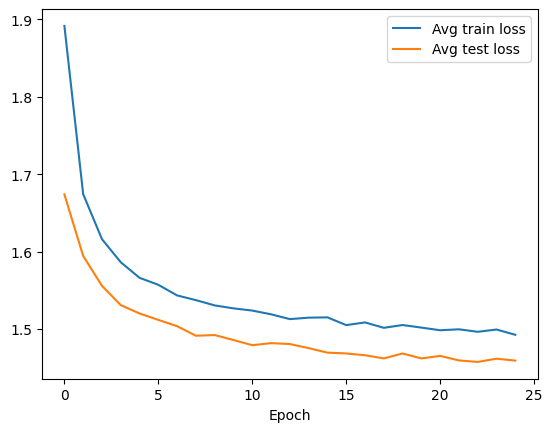

In [60]:
plt.plot(train_loss, label="Avg train loss")
plt.plot(test_loss, label="Avg test loss")
plt.legend()
plt.xlabel("Epoch")
plt.show()


In [61]:
trainset, testset, classes = load_data(DATA, simple_transform(), simple_transform())
trainloader, testloader = create_loaders(
    trainset,
    testset,
    train_batch=16,
    test_batch=32,
)

optim = Adam(model.parameters(), lr=1e-4)
train_loss, test_loss = train(
    model,
    optim,
    loss_function,
    epochs=25,
    device=device,
    trainloader=trainloader,
    testloader=testloader,
    labels=classes
)

Files already downloaded and verified
Files already downloaded and verified


Train #1: 100%|██████████| 3125/3125 [01:04<00:00, 48.47it/s]


Epoch #1 | Train Avg Loss: 1.5538 


Test #1: 100%|██████████| 313/313 [00:07<00:00, 42.29it/s]


Epoch #1 | Test Avg Loss: 1.4517 
              precision    recall  f1-score   support

       plane       0.58      0.54      0.56      1000
         car       0.56      0.61      0.59      1000
        bird       0.36      0.28      0.31      1000
         cat       0.34      0.25      0.29      1000
        deer       0.40      0.39      0.39      1000
         dog       0.43      0.37      0.40      1000
        frog       0.42      0.66      0.52      1000
       horse       0.53      0.53      0.53      1000
        ship       0.60      0.61      0.60      1000
       truck       0.53      0.55      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000



Train #2: 100%|██████████| 3125/3125 [00:58<00:00, 53.73it/s] 


Epoch #2 | Train Avg Loss: 1.5501 


Test #2: 100%|██████████| 313/313 [00:06<00:00, 45.54it/s]


Epoch #2 | Test Avg Loss: 1.4553 
              precision    recall  f1-score   support

       plane       0.59      0.52      0.55      1000
         car       0.62      0.56      0.59      1000
        bird       0.36      0.25      0.29      1000
         cat       0.32      0.30      0.31      1000
        deer       0.38      0.47      0.42      1000
         dog       0.44      0.34      0.39      1000
        frog       0.46      0.61      0.52      1000
       horse       0.50      0.55      0.52      1000
        ship       0.59      0.64      0.61      1000
       truck       0.53      0.58      0.56      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000



Train #3: 100%|██████████| 3125/3125 [00:57<00:00, 53.94it/s] 


Epoch #3 | Train Avg Loss: 1.5467 


Test #3: 100%|██████████| 313/313 [00:07<00:00, 42.28it/s]


Epoch #3 | Test Avg Loss: 1.4562 
              precision    recall  f1-score   support

       plane       0.59      0.53      0.56      1000
         car       0.61      0.58      0.59      1000
        bird       0.36      0.26      0.30      1000
         cat       0.32      0.29      0.30      1000
        deer       0.39      0.44      0.42      1000
         dog       0.43      0.39      0.41      1000
        frog       0.45      0.62      0.52      1000
       horse       0.52      0.55      0.53      1000
        ship       0.59      0.64      0.61      1000
       truck       0.56      0.53      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000



Train #4: 100%|██████████| 3125/3125 [01:03<00:00, 49.29it/s]


Epoch #4 | Train Avg Loss: 1.5475 


Test #4: 100%|██████████| 313/313 [00:09<00:00, 34.61it/s]


Epoch #4 | Test Avg Loss: 1.4532 
              precision    recall  f1-score   support

       plane       0.57      0.54      0.55      1000
         car       0.56      0.62      0.59      1000
        bird       0.37      0.24      0.29      1000
         cat       0.33      0.24      0.28      1000
        deer       0.37      0.43      0.40      1000
         dog       0.45      0.36      0.40      1000
        frog       0.44      0.63      0.52      1000
       horse       0.52      0.53      0.52      1000
        ship       0.57      0.65      0.61      1000
       truck       0.52      0.54      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000



Train #5: 100%|██████████| 3125/3125 [01:26<00:00, 36.01it/s] 


Epoch #5 | Train Avg Loss: 1.5476 


Test #5: 100%|██████████| 313/313 [00:08<00:00, 34.89it/s]


Epoch #5 | Test Avg Loss: 1.4511 
              precision    recall  f1-score   support

       plane       0.58      0.57      0.57      1000
         car       0.59      0.58      0.58      1000
        bird       0.35      0.30      0.32      1000
         cat       0.36      0.24      0.28      1000
        deer       0.39      0.43      0.41      1000
         dog       0.44      0.37      0.40      1000
        frog       0.45      0.64      0.53      1000
       horse       0.52      0.52      0.52      1000
        ship       0.58      0.67      0.62      1000
       truck       0.53      0.54      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000



Train #6: 100%|██████████| 3125/3125 [01:32<00:00, 33.62it/s]


Epoch #6 | Train Avg Loss: 1.5451 


Test #6: 100%|██████████| 313/313 [00:10<00:00, 29.80it/s]


Epoch #6 | Test Avg Loss: 1.4555 
              precision    recall  f1-score   support

       plane       0.57      0.55      0.56      1000
         car       0.61      0.58      0.59      1000
        bird       0.36      0.27      0.31      1000
         cat       0.33      0.24      0.28      1000
        deer       0.39      0.43      0.41      1000
         dog       0.42      0.41      0.42      1000
        frog       0.44      0.67      0.53      1000
       horse       0.52      0.53      0.52      1000
        ship       0.60      0.65      0.62      1000
       truck       0.56      0.51      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000



Train #7: 100%|██████████| 3125/3125 [01:25<00:00, 36.64it/s]


Epoch #7 | Train Avg Loss: 1.5472 


Test #7: 100%|██████████| 313/313 [00:08<00:00, 36.77it/s]


Epoch #7 | Test Avg Loss: 1.4558 
              precision    recall  f1-score   support

       plane       0.57      0.55      0.56      1000
         car       0.61      0.57      0.59      1000
        bird       0.35      0.30      0.32      1000
         cat       0.34      0.24      0.28      1000
        deer       0.38      0.45      0.41      1000
         dog       0.44      0.37      0.40      1000
        frog       0.43      0.62      0.51      1000
       horse       0.55      0.50      0.52      1000
        ship       0.55      0.65      0.60      1000
       truck       0.55      0.52      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.47     10000
weighted avg       0.48      0.48      0.47     10000



Train #8: 100%|██████████| 3125/3125 [01:12<00:00, 43.15it/s]


Epoch #8 | Train Avg Loss: 1.5423 


Test #8: 100%|██████████| 313/313 [00:06<00:00, 48.18it/s]


Epoch #8 | Test Avg Loss: 1.4565 
              precision    recall  f1-score   support

       plane       0.57      0.54      0.56      1000
         car       0.57      0.62      0.59      1000
        bird       0.34      0.28      0.30      1000
         cat       0.35      0.25      0.29      1000
        deer       0.35      0.48      0.40      1000
         dog       0.49      0.34      0.40      1000
        frog       0.44      0.63      0.52      1000
       horse       0.54      0.51      0.53      1000
        ship       0.56      0.66      0.61      1000
       truck       0.57      0.49      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.47     10000
weighted avg       0.48      0.48      0.47     10000



Train #9: 100%|██████████| 3125/3125 [01:02<00:00, 49.74it/s]


Epoch #9 | Train Avg Loss: 1.5418 


Test #9: 100%|██████████| 313/313 [00:07<00:00, 40.70it/s]


Epoch #9 | Test Avg Loss: 1.4549 
              precision    recall  f1-score   support

       plane       0.58      0.53      0.56      1000
         car       0.58      0.58      0.58      1000
        bird       0.37      0.24      0.30      1000
         cat       0.32      0.23      0.27      1000
        deer       0.38      0.43      0.41      1000
         dog       0.43      0.38      0.40      1000
        frog       0.43      0.66      0.52      1000
       horse       0.52      0.54      0.53      1000
        ship       0.61      0.64      0.62      1000
       truck       0.52      0.55      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000



Train #10: 100%|██████████| 3125/3125 [00:59<00:00, 52.55it/s] 


Epoch #10 | Train Avg Loss: 1.5445 


Test #10: 100%|██████████| 313/313 [00:08<00:00, 36.79it/s]


Epoch #10 | Test Avg Loss: 1.4663 
              precision    recall  f1-score   support

       plane       0.58      0.53      0.56      1000
         car       0.60      0.59      0.59      1000
        bird       0.34      0.31      0.32      1000
         cat       0.32      0.27      0.29      1000
        deer       0.39      0.40      0.39      1000
         dog       0.42      0.39      0.41      1000
        frog       0.41      0.67      0.51      1000
       horse       0.57      0.47      0.52      1000
        ship       0.58      0.65      0.61      1000
       truck       0.58      0.47      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.47     10000
weighted avg       0.48      0.48      0.47     10000



Train #11:  10%|▉         | 306/3125 [00:08<01:19, 35.31it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(train_loss, label="Avg train loss")
plt.plot(test_loss, label="Avg test loss")
plt.legend()
plt.xlabel("Epoch")
plt.show()

## Big model 100

In [62]:
trainset, testset, classes = load_data(DATA, simple_transform(), simple_transform())
trainloader, testloader = create_loaders(
    trainset,
    testset,
    train_batch=32,
    test_batch=32,
)

Files already downloaded and verified
Files already downloaded and verified


In [64]:
vae_path = TRAINED_MODELS / "vae_state_dict_aug100"
vae_params = {
    "img_size": 32,
    "downsamplings": 3,
    "latent_size": 128,
    "linear_hidden_size": 256,
    "down_channels": 4,
    "up_channels": 8,
}

vae = VAE(**vae_params)
vae.load_state_dict(torch.load(vae_path, map_location=torch.device('cpu')))

model = ClassificationHead(encoder=vae.encoder, latent_size=vae_params["latent_size"], start_dim=64)
optim = Adam(model.parameters())
loss_function = nn.CrossEntropyLoss()

In [65]:
train_loss, test_loss = train(
    model,
    optim,
    loss_function,
    epochs=40,
    device=device,
    trainloader=trainloader,
    testloader=testloader,
    labels=classes
)

Train #1: 100%|██████████| 1563/1563 [00:57<00:00, 27.08it/s]


Epoch #1 | Train Avg Loss: 1.8758 


Test #1: 100%|██████████| 313/313 [00:09<00:00, 31.51it/s]


Epoch #1 | Test Avg Loss: 1.6572 
              precision    recall  f1-score   support

       plane       0.48      0.49      0.49      1000
         car       0.51      0.57      0.54      1000
        bird       0.31      0.10      0.15      1000
         cat       0.28      0.21      0.24      1000
        deer       0.31      0.38      0.34      1000
         dog       0.40      0.37      0.39      1000
        frog       0.34      0.51      0.41      1000
       horse       0.40      0.44      0.42      1000
        ship       0.53      0.54      0.53      1000
       truck       0.48      0.47      0.48      1000

    accuracy                           0.41     10000
   macro avg       0.40      0.41      0.40     10000
weighted avg       0.40      0.41      0.40     10000



Train #2: 100%|██████████| 1563/1563 [01:07<00:00, 22.99it/s]


Epoch #2 | Train Avg Loss: 1.6619 


Test #2: 100%|██████████| 313/313 [00:11<00:00, 27.58it/s]


Epoch #2 | Test Avg Loss: 1.5665 
              precision    recall  f1-score   support

       plane       0.49      0.53      0.51      1000
         car       0.54      0.53      0.54      1000
        bird       0.34      0.31      0.32      1000
         cat       0.29      0.15      0.20      1000
        deer       0.37      0.37      0.37      1000
         dog       0.39      0.36      0.38      1000
        frog       0.39      0.58      0.47      1000
       horse       0.46      0.49      0.47      1000
        ship       0.53      0.57      0.55      1000
       truck       0.51      0.49      0.50      1000

    accuracy                           0.44     10000
   macro avg       0.43      0.44      0.43     10000
weighted avg       0.43      0.44      0.43     10000



Train #3: 100%|██████████| 1563/1563 [01:07<00:00, 23.22it/s]


Epoch #3 | Train Avg Loss: 1.5894 


Test #3: 100%|██████████| 313/313 [00:11<00:00, 26.35it/s]


Epoch #3 | Test Avg Loss: 1.5163 
              precision    recall  f1-score   support

       plane       0.54      0.55      0.54      1000
         car       0.60      0.51      0.55      1000
        bird       0.34      0.25      0.29      1000
         cat       0.31      0.27      0.29      1000
        deer       0.39      0.35      0.37      1000
         dog       0.44      0.32      0.37      1000
        frog       0.39      0.62      0.48      1000
       horse       0.46      0.55      0.50      1000
        ship       0.57      0.61      0.59      1000
       truck       0.52      0.55      0.54      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.45     10000
weighted avg       0.46      0.46      0.45     10000



Train #4: 100%|██████████| 1563/1563 [01:06<00:00, 23.50it/s]


Epoch #4 | Train Avg Loss: 1.5499 


Test #4: 100%|██████████| 313/313 [00:12<00:00, 25.86it/s]


Epoch #4 | Test Avg Loss: 1.4834 
              precision    recall  f1-score   support

       plane       0.52      0.53      0.53      1000
         car       0.58      0.56      0.57      1000
        bird       0.36      0.26      0.30      1000
         cat       0.31      0.30      0.30      1000
        deer       0.38      0.39      0.39      1000
         dog       0.41      0.35      0.38      1000
        frog       0.46      0.56      0.50      1000
       horse       0.51      0.50      0.51      1000
        ship       0.55      0.66      0.60      1000
       truck       0.51      0.55      0.53      1000

    accuracy                           0.47     10000
   macro avg       0.46      0.47      0.46     10000
weighted avg       0.46      0.47      0.46     10000



Train #5: 100%|██████████| 1563/1563 [01:07<00:00, 23.11it/s]


Epoch #5 | Train Avg Loss: 1.5189 


Test #5: 100%|██████████| 313/313 [00:12<00:00, 24.35it/s]


Epoch #5 | Test Avg Loss: 1.4678 
              precision    recall  f1-score   support

       plane       0.58      0.49      0.53      1000
         car       0.60      0.56      0.58      1000
        bird       0.37      0.21      0.27      1000
         cat       0.31      0.25      0.28      1000
        deer       0.38      0.47      0.42      1000
         dog       0.43      0.34      0.38      1000
        frog       0.40      0.63      0.49      1000
       horse       0.53      0.51      0.52      1000
        ship       0.59      0.64      0.62      1000
       truck       0.50      0.59      0.54      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.46     10000
weighted avg       0.47      0.47      0.46     10000



Train #6: 100%|██████████| 1563/1563 [01:07<00:00, 23.06it/s]


Epoch #6 | Train Avg Loss: 1.4973 


Test #6: 100%|██████████| 313/313 [00:11<00:00, 27.15it/s]


Epoch #6 | Test Avg Loss: 1.4551 
              precision    recall  f1-score   support

       plane       0.53      0.59      0.56      1000
         car       0.58      0.60      0.59      1000
        bird       0.36      0.26      0.30      1000
         cat       0.33      0.33      0.33      1000
        deer       0.38      0.44      0.41      1000
         dog       0.46      0.31      0.37      1000
        frog       0.46      0.53      0.49      1000
       horse       0.54      0.52      0.53      1000
        ship       0.53      0.64      0.58      1000
       truck       0.53      0.50      0.51      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000
weighted avg       0.47      0.47      0.47     10000



Train #7: 100%|██████████| 1563/1563 [01:05<00:00, 23.93it/s]


Epoch #7 | Train Avg Loss: 1.4857 


Test #7: 100%|██████████| 313/313 [00:11<00:00, 26.23it/s]


Epoch #7 | Test Avg Loss: 1.4383 
              precision    recall  f1-score   support

       plane       0.55      0.54      0.54      1000
         car       0.59      0.56      0.57      1000
        bird       0.36      0.34      0.35      1000
         cat       0.35      0.20      0.25      1000
        deer       0.41      0.39      0.40      1000
         dog       0.40      0.41      0.41      1000
        frog       0.48      0.54      0.51      1000
       horse       0.52      0.60      0.56      1000
        ship       0.55      0.67      0.60      1000
       truck       0.52      0.55      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000



Train #8: 100%|██████████| 1563/1563 [01:10<00:00, 22.25it/s]


Epoch #8 | Train Avg Loss: 1.4719 


Test #8: 100%|██████████| 313/313 [00:11<00:00, 26.49it/s]


Epoch #8 | Test Avg Loss: 1.4373 
              precision    recall  f1-score   support

       plane       0.56      0.55      0.56      1000
         car       0.61      0.59      0.60      1000
        bird       0.37      0.30      0.33      1000
         cat       0.33      0.32      0.32      1000
        deer       0.38      0.45      0.41      1000
         dog       0.45      0.34      0.39      1000
        frog       0.45      0.54      0.49      1000
       horse       0.55      0.56      0.56      1000
        ship       0.57      0.69      0.62      1000
       truck       0.54      0.50      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000



Train #9: 100%|██████████| 1563/1563 [01:06<00:00, 23.65it/s]


Epoch #9 | Train Avg Loss: 1.4624 


Test #9: 100%|██████████| 313/313 [00:11<00:00, 26.91it/s]


Epoch #9 | Test Avg Loss: 1.4276 
              precision    recall  f1-score   support

       plane       0.55      0.54      0.54      1000
         car       0.58      0.64      0.61      1000
        bird       0.38      0.28      0.33      1000
         cat       0.33      0.27      0.30      1000
        deer       0.39      0.43      0.41      1000
         dog       0.43      0.36      0.39      1000
        frog       0.45      0.59      0.51      1000
       horse       0.49      0.61      0.54      1000
        ship       0.60      0.62      0.61      1000
       truck       0.59      0.49      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000



Train #10: 100%|██████████| 1563/1563 [01:04<00:00, 24.06it/s]


Epoch #10 | Train Avg Loss: 1.4509 


Test #10: 100%|██████████| 313/313 [00:11<00:00, 27.74it/s]


Epoch #10 | Test Avg Loss: 1.4249 
              precision    recall  f1-score   support

       plane       0.55      0.56      0.56      1000
         car       0.57      0.66      0.61      1000
        bird       0.38      0.29      0.33      1000
         cat       0.32      0.34      0.33      1000
        deer       0.40      0.39      0.39      1000
         dog       0.43      0.34      0.38      1000
        frog       0.49      0.58      0.53      1000
       horse       0.53      0.58      0.55      1000
        ship       0.63      0.61      0.62      1000
       truck       0.53      0.53      0.53      1000

    accuracy                           0.49     10000
   macro avg       0.48      0.49      0.48     10000
weighted avg       0.48      0.49      0.48     10000



Train #11: 100%|██████████| 1563/1563 [01:04<00:00, 24.39it/s]


Epoch #11 | Train Avg Loss: 1.4435 


Test #11: 100%|██████████| 313/313 [00:11<00:00, 26.87it/s]


Epoch #11 | Test Avg Loss: 1.4206 
              precision    recall  f1-score   support

       plane       0.55      0.56      0.55      1000
         car       0.60      0.63      0.62      1000
        bird       0.40      0.33      0.36      1000
         cat       0.33      0.32      0.32      1000
        deer       0.42      0.38      0.40      1000
         dog       0.42      0.37      0.39      1000
        frog       0.45      0.60      0.52      1000
       horse       0.56      0.56      0.56      1000
        ship       0.58      0.66      0.62      1000
       truck       0.56      0.51      0.54      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



Train #12: 100%|██████████| 1563/1563 [01:04<00:00, 24.29it/s]


Epoch #12 | Train Avg Loss: 1.4405 


Test #12: 100%|██████████| 313/313 [00:11<00:00, 27.32it/s]


Epoch #12 | Test Avg Loss: 1.4104 
              precision    recall  f1-score   support

       plane       0.55      0.57      0.56      1000
         car       0.61      0.62      0.61      1000
        bird       0.37      0.32      0.34      1000
         cat       0.32      0.27      0.29      1000
        deer       0.42      0.39      0.40      1000
         dog       0.41      0.40      0.40      1000
        frog       0.48      0.61      0.54      1000
       horse       0.54      0.56      0.55      1000
        ship       0.60      0.65      0.62      1000
       truck       0.56      0.54      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



Train #13: 100%|██████████| 1563/1563 [01:03<00:00, 24.52it/s]


Epoch #13 | Train Avg Loss: 1.4320 


Test #13: 100%|██████████| 313/313 [00:10<00:00, 28.90it/s]


Epoch #13 | Test Avg Loss: 1.4115 
              precision    recall  f1-score   support

       plane       0.54      0.59      0.56      1000
         car       0.57      0.65      0.61      1000
        bird       0.36      0.37      0.36      1000
         cat       0.34      0.24      0.28      1000
        deer       0.40      0.36      0.38      1000
         dog       0.44      0.33      0.38      1000
        frog       0.50      0.56      0.53      1000
       horse       0.50      0.60      0.54      1000
        ship       0.59      0.64      0.62      1000
       truck       0.55      0.55      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.48      0.49      0.48     10000
weighted avg       0.48      0.49      0.48     10000



Train #14: 100%|██████████| 1563/1563 [01:09<00:00, 22.36it/s]


Epoch #14 | Train Avg Loss: 1.4258 


Test #14: 100%|██████████| 313/313 [00:10<00:00, 28.62it/s]


Epoch #14 | Test Avg Loss: 1.4012 
              precision    recall  f1-score   support

       plane       0.56      0.54      0.55      1000
         car       0.60      0.61      0.61      1000
        bird       0.39      0.36      0.37      1000
         cat       0.36      0.21      0.27      1000
        deer       0.41      0.40      0.40      1000
         dog       0.40      0.42      0.41      1000
        frog       0.47      0.61      0.53      1000
       horse       0.56      0.57      0.56      1000
        ship       0.59      0.64      0.62      1000
       truck       0.54      0.58      0.56      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



Train #15: 100%|██████████| 1563/1563 [01:02<00:00, 25.04it/s]


Epoch #15 | Train Avg Loss: 1.4193 


Test #15: 100%|██████████| 313/313 [00:10<00:00, 29.58it/s]


Epoch #15 | Test Avg Loss: 1.3989 
              precision    recall  f1-score   support

       plane       0.60      0.56      0.58      1000
         car       0.62      0.59      0.61      1000
        bird       0.38      0.37      0.37      1000
         cat       0.33      0.28      0.30      1000
        deer       0.42      0.41      0.41      1000
         dog       0.40      0.43      0.42      1000
        frog       0.51      0.54      0.52      1000
       horse       0.57      0.55      0.55      1000
        ship       0.55      0.69      0.61      1000
       truck       0.57      0.53      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



Train #16: 100%|██████████| 1563/1563 [01:08<00:00, 22.87it/s]


Epoch #16 | Train Avg Loss: 1.4181 


Test #16: 100%|██████████| 313/313 [00:16<00:00, 19.53it/s]


Epoch #16 | Test Avg Loss: 1.4035 
              precision    recall  f1-score   support

       plane       0.58      0.55      0.57      1000
         car       0.60      0.61      0.61      1000
        bird       0.39      0.29      0.33      1000
         cat       0.32      0.34      0.33      1000
        deer       0.42      0.43      0.42      1000
         dog       0.45      0.32      0.37      1000
        frog       0.46      0.63      0.53      1000
       horse       0.58      0.54      0.56      1000
        ship       0.61      0.64      0.63      1000
       truck       0.51      0.59      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000



Train #17: 100%|██████████| 1563/1563 [01:23<00:00, 18.67it/s]


Epoch #17 | Train Avg Loss: 1.4071 


Test #17: 100%|██████████| 313/313 [00:30<00:00, 10.24it/s]


Epoch #17 | Test Avg Loss: 1.4048 
              precision    recall  f1-score   support

       plane       0.54      0.55      0.54      1000
         car       0.61      0.60      0.61      1000
        bird       0.40      0.35      0.37      1000
         cat       0.34      0.28      0.31      1000
        deer       0.41      0.44      0.42      1000
         dog       0.47      0.33      0.39      1000
        frog       0.45      0.65      0.53      1000
       horse       0.54      0.59      0.56      1000
        ship       0.60      0.65      0.62      1000
       truck       0.57      0.53      0.55      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000



Train #18: 100%|██████████| 1563/1563 [01:12<00:00, 21.62it/s]


Epoch #18 | Train Avg Loss: 1.4068 


Test #18: 100%|██████████| 313/313 [00:11<00:00, 28.25it/s]


Epoch #18 | Test Avg Loss: 1.3976 
              precision    recall  f1-score   support

       plane       0.60      0.51      0.55      1000
         car       0.58      0.61      0.60      1000
        bird       0.42      0.31      0.36      1000
         cat       0.34      0.35      0.34      1000
        deer       0.42      0.45      0.43      1000
         dog       0.49      0.27      0.35      1000
        frog       0.48      0.61      0.54      1000
       horse       0.54      0.57      0.56      1000
        ship       0.57      0.69      0.63      1000
       truck       0.51      0.60      0.55      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000



Train #19: 100%|██████████| 1563/1563 [01:09<00:00, 22.42it/s]


Epoch #19 | Train Avg Loss: 1.4005 


Test #19: 100%|██████████| 313/313 [00:17<00:00, 18.34it/s]


Epoch #19 | Test Avg Loss: 1.3922 
              precision    recall  f1-score   support

       plane       0.57      0.58      0.58      1000
         car       0.58      0.67      0.62      1000
        bird       0.40      0.29      0.34      1000
         cat       0.34      0.29      0.32      1000
        deer       0.42      0.39      0.40      1000
         dog       0.45      0.34      0.39      1000
        frog       0.46      0.65      0.54      1000
       horse       0.52      0.60      0.56      1000
        ship       0.62      0.65      0.63      1000
       truck       0.56      0.52      0.54      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000



Train #20: 100%|██████████| 1563/1563 [01:35<00:00, 16.31it/s]


Epoch #20 | Train Avg Loss: 1.3974 


Test #20: 100%|██████████| 313/313 [00:14<00:00, 21.97it/s]


Epoch #20 | Test Avg Loss: 1.3994 
              precision    recall  f1-score   support

       plane       0.54      0.61      0.57      1000
         car       0.57      0.65      0.60      1000
        bird       0.39      0.36      0.38      1000
         cat       0.36      0.30      0.33      1000
        deer       0.42      0.38      0.40      1000
         dog       0.47      0.29      0.36      1000
        frog       0.48      0.63      0.55      1000
       horse       0.55      0.56      0.55      1000
        ship       0.58      0.66      0.62      1000
       truck       0.54      0.54      0.54      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000



Train #21: 100%|██████████| 1563/1563 [00:59<00:00, 26.34it/s]


Epoch #21 | Train Avg Loss: 1.3962 


Test #21: 100%|██████████| 313/313 [00:06<00:00, 49.01it/s]


Epoch #21 | Test Avg Loss: 1.3959 
              precision    recall  f1-score   support

       plane       0.53      0.61      0.57      1000
         car       0.62      0.63      0.62      1000
        bird       0.39      0.32      0.35      1000
         cat       0.35      0.29      0.31      1000
        deer       0.42      0.42      0.42      1000
         dog       0.41      0.39      0.40      1000
        frog       0.50      0.57      0.53      1000
       horse       0.54      0.57      0.56      1000
        ship       0.60      0.65      0.62      1000
       truck       0.57      0.52      0.54      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000



Train #22: 100%|██████████| 1563/1563 [00:39<00:00, 39.95it/s]


Epoch #22 | Train Avg Loss: 1.3969 


Test #22: 100%|██████████| 313/313 [00:06<00:00, 49.50it/s]


Epoch #22 | Test Avg Loss: 1.3861 
              precision    recall  f1-score   support

       plane       0.56      0.58      0.57      1000
         car       0.61      0.62      0.61      1000
        bird       0.43      0.32      0.36      1000
         cat       0.34      0.34      0.34      1000
        deer       0.43      0.40      0.41      1000
         dog       0.42      0.36      0.39      1000
        frog       0.49      0.62      0.55      1000
       horse       0.56      0.57      0.56      1000
        ship       0.58      0.65      0.61      1000
       truck       0.52      0.57      0.54      1000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



Train #23: 100%|██████████| 1563/1563 [00:41<00:00, 37.86it/s]


Epoch #23 | Train Avg Loss: 1.3907 


Test #23: 100%|██████████| 313/313 [00:07<00:00, 44.37it/s]


Epoch #23 | Test Avg Loss: 1.3942 
              precision    recall  f1-score   support

       plane       0.57      0.58      0.57      1000
         car       0.57      0.64      0.60      1000
        bird       0.38      0.35      0.36      1000
         cat       0.34      0.27      0.30      1000
        deer       0.42      0.39      0.40      1000
         dog       0.44      0.38      0.41      1000
        frog       0.48      0.64      0.55      1000
       horse       0.54      0.59      0.56      1000
        ship       0.65      0.63      0.64      1000
       truck       0.56      0.54      0.55      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000



Train #24: 100%|██████████| 1563/1563 [00:41<00:00, 37.60it/s]


Epoch #24 | Train Avg Loss: 1.3948 


Test #24: 100%|██████████| 313/313 [00:06<00:00, 45.92it/s]


Epoch #24 | Test Avg Loss: 1.3795 
              precision    recall  f1-score   support

       plane       0.58      0.57      0.58      1000
         car       0.59      0.64      0.61      1000
        bird       0.41      0.32      0.36      1000
         cat       0.35      0.28      0.31      1000
        deer       0.44      0.39      0.41      1000
         dog       0.42      0.43      0.42      1000
        frog       0.48      0.61      0.54      1000
       horse       0.54      0.58      0.56      1000
        ship       0.63      0.66      0.64      1000
       truck       0.55      0.58      0.56      1000

    accuracy                           0.51     10000
   macro avg       0.50      0.51      0.50     10000
weighted avg       0.50      0.51      0.50     10000



Train #25: 100%|██████████| 1563/1563 [00:39<00:00, 39.77it/s]


Epoch #25 | Train Avg Loss: 1.3879 


Test #25: 100%|██████████| 313/313 [00:06<00:00, 51.20it/s]


Epoch #25 | Test Avg Loss: 1.3839 
              precision    recall  f1-score   support

       plane       0.58      0.58      0.58      1000
         car       0.60      0.61      0.61      1000
        bird       0.40      0.33      0.36      1000
         cat       0.31      0.34      0.33      1000
        deer       0.43      0.36      0.39      1000
         dog       0.44      0.36      0.39      1000
        frog       0.48      0.64      0.55      1000
       horse       0.58      0.55      0.56      1000
        ship       0.59      0.68      0.63      1000
       truck       0.53      0.53      0.53      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000



Train #26: 100%|██████████| 1563/1563 [00:38<00:00, 40.49it/s]


Epoch #26 | Train Avg Loss: 1.3861 


Test #26: 100%|██████████| 313/313 [00:06<00:00, 48.02it/s]


Epoch #26 | Test Avg Loss: 1.3863 
              precision    recall  f1-score   support

       plane       0.56      0.52      0.54      1000
         car       0.61      0.63      0.62      1000
        bird       0.36      0.39      0.37      1000
         cat       0.34      0.31      0.33      1000
        deer       0.42      0.40      0.41      1000
         dog       0.44      0.37      0.40      1000
        frog       0.52      0.57      0.54      1000
       horse       0.57      0.57      0.57      1000
        ship       0.55      0.71      0.62      1000
       truck       0.58      0.50      0.54      1000

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.49      0.50      0.49     10000



Train #27: 100%|██████████| 1563/1563 [00:41<00:00, 38.12it/s]


Epoch #27 | Train Avg Loss: 1.3799 


Test #27: 100%|██████████| 313/313 [00:05<00:00, 54.92it/s]


Epoch #27 | Test Avg Loss: 1.3830 
              precision    recall  f1-score   support

       plane       0.57      0.57      0.57      1000
         car       0.61      0.63      0.62      1000
        bird       0.38      0.32      0.35      1000
         cat       0.35      0.35      0.35      1000
        deer       0.44      0.40      0.41      1000
         dog       0.44      0.33      0.38      1000
        frog       0.45      0.65      0.53      1000
       horse       0.57      0.57      0.57      1000
        ship       0.62      0.65      0.63      1000
       truck       0.57      0.55      0.56      1000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



Train #28: 100%|██████████| 1563/1563 [00:41<00:00, 37.95it/s]


Epoch #28 | Train Avg Loss: 1.3801 


Test #28: 100%|██████████| 313/313 [00:06<00:00, 45.01it/s]


Epoch #28 | Test Avg Loss: 1.3828 
              precision    recall  f1-score   support

       plane       0.56      0.56      0.56      1000
         car       0.59      0.64      0.61      1000
        bird       0.40      0.35      0.37      1000
         cat       0.34      0.30      0.32      1000
        deer       0.45      0.36      0.40      1000
         dog       0.43      0.39      0.41      1000
        frog       0.50      0.61      0.55      1000
       horse       0.57      0.57      0.57      1000
        ship       0.57      0.71      0.63      1000
       truck       0.56      0.52      0.54      1000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



Train #29: 100%|██████████| 1563/1563 [00:40<00:00, 38.38it/s]


Epoch #29 | Train Avg Loss: 1.3763 


Test #29: 100%|██████████| 313/313 [00:05<00:00, 56.99it/s]


Epoch #29 | Test Avg Loss: 1.3731 
              precision    recall  f1-score   support

       plane       0.58      0.58      0.58      1000
         car       0.58      0.65      0.61      1000
        bird       0.39      0.36      0.38      1000
         cat       0.36      0.35      0.35      1000
        deer       0.42      0.38      0.40      1000
         dog       0.48      0.32      0.38      1000
        frog       0.50      0.61      0.55      1000
       horse       0.56      0.60      0.58      1000
        ship       0.60      0.68      0.63      1000
       truck       0.55      0.55      0.55      1000

    accuracy                           0.51     10000
   macro avg       0.50      0.51      0.50     10000
weighted avg       0.50      0.51      0.50     10000



Train #30: 100%|██████████| 1563/1563 [00:40<00:00, 38.95it/s]


Epoch #30 | Train Avg Loss: 1.3765 


Test #30: 100%|██████████| 313/313 [00:07<00:00, 40.87it/s]


Epoch #30 | Test Avg Loss: 1.3795 
              precision    recall  f1-score   support

       plane       0.56      0.59      0.58      1000
         car       0.60      0.66      0.63      1000
        bird       0.40      0.30      0.34      1000
         cat       0.34      0.31      0.33      1000
        deer       0.41      0.44      0.42      1000
         dog       0.42      0.37      0.39      1000
        frog       0.47      0.68      0.56      1000
       horse       0.59      0.54      0.57      1000
        ship       0.64      0.62      0.63      1000
       truck       0.58      0.51      0.54      1000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



Train #31: 100%|██████████| 1563/1563 [00:39<00:00, 39.70it/s]


Epoch #31 | Train Avg Loss: 1.3722 


Test #31: 100%|██████████| 313/313 [00:06<00:00, 48.96it/s]


Epoch #31 | Test Avg Loss: 1.3681 
              precision    recall  f1-score   support

       plane       0.57      0.58      0.58      1000
         car       0.64      0.60      0.62      1000
        bird       0.42      0.36      0.38      1000
         cat       0.34      0.28      0.31      1000
        deer       0.41      0.45      0.43      1000
         dog       0.44      0.38      0.41      1000
        frog       0.50      0.59      0.54      1000
       horse       0.55      0.58      0.57      1000
        ship       0.60      0.67      0.63      1000
       truck       0.54      0.55      0.54      1000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



Train #32: 100%|██████████| 1563/1563 [00:40<00:00, 38.61it/s]


Epoch #32 | Train Avg Loss: 1.3745 


Test #32: 100%|██████████| 313/313 [00:06<00:00, 47.20it/s]


Epoch #32 | Test Avg Loss: 1.3783 
              precision    recall  f1-score   support

       plane       0.58      0.60      0.59      1000
         car       0.60      0.62      0.61      1000
        bird       0.42      0.34      0.38      1000
         cat       0.36      0.32      0.34      1000
        deer       0.45      0.36      0.40      1000
         dog       0.46      0.34      0.39      1000
        frog       0.47      0.69      0.56      1000
       horse       0.58      0.56      0.57      1000
        ship       0.60      0.70      0.64      1000
       truck       0.53      0.58      0.55      1000

    accuracy                           0.51     10000
   macro avg       0.50      0.51      0.50     10000
weighted avg       0.50      0.51      0.50     10000



Train #33: 100%|██████████| 1563/1563 [00:39<00:00, 39.22it/s]


Epoch #33 | Train Avg Loss: 1.3699 


Test #33: 100%|██████████| 313/313 [00:06<00:00, 47.40it/s]


Epoch #33 | Test Avg Loss: 1.3770 
              precision    recall  f1-score   support

       plane       0.59      0.57      0.58      1000
         car       0.59      0.61      0.60      1000
        bird       0.38      0.36      0.37      1000
         cat       0.35      0.28      0.31      1000
        deer       0.42      0.39      0.40      1000
         dog       0.45      0.37      0.41      1000
        frog       0.47      0.66      0.55      1000
       horse       0.57      0.57      0.57      1000
        ship       0.58      0.69      0.63      1000
       truck       0.54      0.52      0.53      1000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



Train #34: 100%|██████████| 1563/1563 [00:36<00:00, 43.11it/s]


Epoch #34 | Train Avg Loss: 1.3686 


Test #34: 100%|██████████| 313/313 [00:08<00:00, 35.41it/s]


Epoch #34 | Test Avg Loss: 1.3769 
              precision    recall  f1-score   support

       plane       0.58      0.60      0.59      1000
         car       0.59      0.68      0.63      1000
        bird       0.42      0.30      0.35      1000
         cat       0.36      0.26      0.30      1000
        deer       0.43      0.37      0.40      1000
         dog       0.41      0.39      0.40      1000
        frog       0.44      0.71      0.54      1000
       horse       0.57      0.56      0.56      1000
        ship       0.63      0.65      0.64      1000
       truck       0.56      0.53      0.54      1000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



Train #35: 100%|██████████| 1563/1563 [00:41<00:00, 37.55it/s]


Epoch #35 | Train Avg Loss: 1.3691 


Test #35: 100%|██████████| 313/313 [00:06<00:00, 47.37it/s]


Epoch #35 | Test Avg Loss: 1.3686 
              precision    recall  f1-score   support

       plane       0.57      0.61      0.59      1000
         car       0.62      0.58      0.60      1000
        bird       0.41      0.33      0.37      1000
         cat       0.34      0.34      0.34      1000
        deer       0.43      0.39      0.41      1000
         dog       0.47      0.32      0.38      1000
        frog       0.50      0.64      0.56      1000
       horse       0.54      0.59      0.56      1000
        ship       0.62      0.66      0.64      1000
       truck       0.53      0.59      0.56      1000

    accuracy                           0.51     10000
   macro avg       0.50      0.51      0.50     10000
weighted avg       0.50      0.51      0.50     10000



Train #36: 100%|██████████| 1563/1563 [00:40<00:00, 38.44it/s]


Epoch #36 | Train Avg Loss: 1.3677 


Test #36: 100%|██████████| 313/313 [00:07<00:00, 43.07it/s]


Epoch #36 | Test Avg Loss: 1.3713 
              precision    recall  f1-score   support

       plane       0.58      0.58      0.58      1000
         car       0.59      0.66      0.62      1000
        bird       0.42      0.31      0.35      1000
         cat       0.35      0.24      0.28      1000
        deer       0.41      0.48      0.44      1000
         dog       0.43      0.42      0.43      1000
        frog       0.49      0.65      0.56      1000
       horse       0.57      0.57      0.57      1000
        ship       0.60      0.66      0.63      1000
       truck       0.58      0.52      0.54      1000

    accuracy                           0.51     10000
   macro avg       0.50      0.51      0.50     10000
weighted avg       0.50      0.51      0.50     10000



Train #37: 100%|██████████| 1563/1563 [00:39<00:00, 39.24it/s]


Epoch #37 | Train Avg Loss: 1.3671 


Test #37: 100%|██████████| 313/313 [00:06<00:00, 47.90it/s]


Epoch #37 | Test Avg Loss: 1.3629 
              precision    recall  f1-score   support

       plane       0.63      0.57      0.60      1000
         car       0.60      0.64      0.62      1000
        bird       0.41      0.34      0.37      1000
         cat       0.34      0.32      0.33      1000
        deer       0.44      0.39      0.41      1000
         dog       0.47      0.34      0.39      1000
        frog       0.48      0.66      0.56      1000
       horse       0.56      0.58      0.57      1000
        ship       0.60      0.68      0.64      1000
       truck       0.53      0.58      0.56      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



Train #38: 100%|██████████| 1563/1563 [00:39<00:00, 39.74it/s]


Epoch #38 | Train Avg Loss: 1.3603 


Test #38: 100%|██████████| 313/313 [00:06<00:00, 48.25it/s]


Epoch #38 | Test Avg Loss: 1.3739 
              precision    recall  f1-score   support

       plane       0.57      0.60      0.58      1000
         car       0.61      0.66      0.63      1000
        bird       0.43      0.29      0.35      1000
         cat       0.34      0.35      0.35      1000
        deer       0.40      0.50      0.44      1000
         dog       0.46      0.33      0.39      1000
        frog       0.49      0.63      0.55      1000
       horse       0.57      0.56      0.57      1000
        ship       0.66      0.62      0.64      1000
       truck       0.57      0.54      0.56      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.50     10000
weighted avg       0.51      0.51      0.50     10000



Train #39: 100%|██████████| 1563/1563 [00:51<00:00, 30.20it/s]


Epoch #39 | Train Avg Loss: 1.3619 


Test #39: 100%|██████████| 313/313 [00:09<00:00, 32.36it/s]


Epoch #39 | Test Avg Loss: 1.3616 
              precision    recall  f1-score   support

       plane       0.59      0.59      0.59      1000
         car       0.61      0.68      0.64      1000
        bird       0.40      0.33      0.36      1000
         cat       0.34      0.34      0.34      1000
        deer       0.44      0.40      0.42      1000
         dog       0.44      0.39      0.41      1000
        frog       0.50      0.64      0.56      1000
       horse       0.56      0.60      0.58      1000
        ship       0.63      0.66      0.65      1000
       truck       0.58      0.52      0.55      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



Train #40: 100%|██████████| 1563/1563 [00:50<00:00, 31.05it/s]


Epoch #40 | Train Avg Loss: 1.3593 


Test #40: 100%|██████████| 313/313 [00:10<00:00, 29.53it/s]

Epoch #40 | Test Avg Loss: 1.3738 
              precision    recall  f1-score   support

       plane       0.60      0.57      0.59      1000
         car       0.60      0.60      0.60      1000
        bird       0.44      0.32      0.37      1000
         cat       0.35      0.28      0.31      1000
        deer       0.42      0.40      0.41      1000
         dog       0.42      0.41      0.42      1000
        frog       0.48      0.66      0.55      1000
       horse       0.54      0.61      0.57      1000
        ship       0.61      0.68      0.64      1000
       truck       0.54      0.54      0.54      1000

    accuracy                           0.51     10000
   macro avg       0.50      0.51      0.50     10000
weighted avg       0.50      0.51      0.50     10000



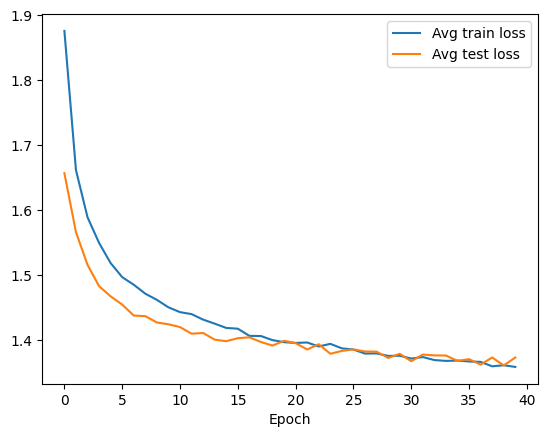

In [66]:
plt.plot(train_loss, label="Avg train loss")
plt.plot(test_loss, label="Avg test loss")
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [67]:
torch.save(model.state_dict(), TRAINED_MODELS / "vae_state_dict_aug100_cls")

In [68]:
optim = Adam(model.parameters(), lr=1e-4)
train_loss, test_loss = train(
    model,
    optim,
    loss_function,
    epochs=10,
    device=device,
    trainloader=trainloader,
    testloader=testloader,
    labels=classes
)

Train #1: 100%|██████████| 1563/1563 [02:32<00:00, 10.26it/s]


Epoch #1 | Train Avg Loss: 1.3394 


Test #1: 100%|██████████| 313/313 [00:19<00:00, 15.99it/s]


Epoch #1 | Test Avg Loss: 1.3588 
              precision    recall  f1-score   support

       plane       0.59      0.59      0.59      1000
         car       0.60      0.66      0.63      1000
        bird       0.40      0.35      0.37      1000
         cat       0.33      0.28      0.30      1000
        deer       0.43      0.39      0.41      1000
         dog       0.42      0.42      0.42      1000
        frog       0.50      0.62      0.56      1000
       horse       0.57      0.59      0.58      1000
        ship       0.61      0.67      0.64      1000
       truck       0.58      0.53      0.55      1000

    accuracy                           0.51     10000
   macro avg       0.50      0.51      0.51     10000
weighted avg       0.50      0.51      0.51     10000



Train #2: 100%|██████████| 1563/1563 [02:06<00:00, 12.39it/s]


Epoch #2 | Train Avg Loss: 1.3338 


Test #2: 100%|██████████| 313/313 [00:21<00:00, 14.61it/s]


Epoch #2 | Test Avg Loss: 1.3540 
              precision    recall  f1-score   support

       plane       0.57      0.63      0.60      1000
         car       0.59      0.68      0.63      1000
        bird       0.43      0.34      0.38      1000
         cat       0.35      0.30      0.32      1000
        deer       0.45      0.39      0.42      1000
         dog       0.44      0.38      0.40      1000
        frog       0.49      0.66      0.56      1000
       horse       0.58      0.56      0.57      1000
        ship       0.62      0.66      0.64      1000
       truck       0.55      0.54      0.54      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



Train #3: 100%|██████████| 1563/1563 [01:49<00:00, 14.29it/s]


Epoch #3 | Train Avg Loss: 1.3268 


Test #3: 100%|██████████| 313/313 [00:14<00:00, 21.33it/s]


Epoch #3 | Test Avg Loss: 1.3463 
              precision    recall  f1-score   support

       plane       0.58      0.61      0.60      1000
         car       0.59      0.68      0.63      1000
        bird       0.42      0.33      0.37      1000
         cat       0.35      0.33      0.34      1000
        deer       0.42      0.44      0.43      1000
         dog       0.48      0.34      0.40      1000
        frog       0.52      0.64      0.57      1000
       horse       0.56      0.59      0.57      1000
        ship       0.63      0.65      0.64      1000
       truck       0.56      0.55      0.55      1000

    accuracy                           0.52     10000
   macro avg       0.51      0.52      0.51     10000
weighted avg       0.51      0.52      0.51     10000



Train #4: 100%|██████████| 1563/1563 [03:32<00:00,  7.36it/s]


Epoch #4 | Train Avg Loss: 1.3269 


Test #4: 100%|██████████| 313/313 [00:43<00:00,  7.13it/s]


Epoch #4 | Test Avg Loss: 1.3570 
              precision    recall  f1-score   support

       plane       0.58      0.62      0.60      1000
         car       0.61      0.65      0.63      1000
        bird       0.39      0.37      0.38      1000
         cat       0.35      0.28      0.31      1000
        deer       0.42      0.41      0.42      1000
         dog       0.45      0.37      0.41      1000
        frog       0.50      0.62      0.55      1000
       horse       0.56      0.57      0.57      1000
        ship       0.60      0.67      0.64      1000
       truck       0.58      0.54      0.56      1000

    accuracy                           0.51     10000
   macro avg       0.50      0.51      0.51     10000
weighted avg       0.50      0.51      0.51     10000



Train #5: 100%|██████████| 1563/1563 [01:52<00:00, 13.87it/s]


Epoch #5 | Train Avg Loss: 1.3276 


Test #5: 100%|██████████| 313/313 [00:24<00:00, 12.88it/s]


Epoch #5 | Test Avg Loss: 1.3511 
              precision    recall  f1-score   support

       plane       0.58      0.59      0.59      1000
         car       0.62      0.66      0.64      1000
        bird       0.39      0.35      0.37      1000
         cat       0.35      0.32      0.33      1000
        deer       0.43      0.42      0.42      1000
         dog       0.46      0.35      0.40      1000
        frog       0.49      0.67      0.56      1000
       horse       0.62      0.54      0.58      1000
        ship       0.61      0.69      0.65      1000
       truck       0.56      0.55      0.55      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



Train #6: 100%|██████████| 1563/1563 [01:27<00:00, 17.89it/s]


Epoch #6 | Train Avg Loss: 1.3239 


Test #6: 100%|██████████| 313/313 [00:16<00:00, 19.28it/s]


Epoch #6 | Test Avg Loss: 1.3510 
              precision    recall  f1-score   support

       plane       0.56      0.62      0.59      1000
         car       0.62      0.62      0.62      1000
        bird       0.40      0.34      0.37      1000
         cat       0.35      0.31      0.33      1000
        deer       0.41      0.43      0.42      1000
         dog       0.44      0.38      0.41      1000
        frog       0.52      0.62      0.57      1000
       horse       0.58      0.59      0.58      1000
        ship       0.61      0.67      0.64      1000
       truck       0.57      0.52      0.54      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



Train #7: 100%|██████████| 1563/1563 [01:39<00:00, 15.77it/s]


Epoch #7 | Train Avg Loss: 1.3260 


Test #7: 100%|██████████| 313/313 [00:16<00:00, 19.54it/s]


Epoch #7 | Test Avg Loss: 1.3475 
              precision    recall  f1-score   support

       plane       0.59      0.61      0.60      1000
         car       0.61      0.63      0.62      1000
        bird       0.41      0.37      0.39      1000
         cat       0.35      0.31      0.33      1000
        deer       0.43      0.43      0.43      1000
         dog       0.45      0.36      0.40      1000
        frog       0.52      0.62      0.57      1000
       horse       0.58      0.57      0.58      1000
        ship       0.62      0.67      0.64      1000
       truck       0.53      0.58      0.55      1000

    accuracy                           0.52     10000
   macro avg       0.51      0.52      0.51     10000
weighted avg       0.51      0.52      0.51     10000



Train #8: 100%|██████████| 1563/1563 [01:27<00:00, 17.90it/s]


Epoch #8 | Train Avg Loss: 1.3213 


Test #8: 100%|██████████| 313/313 [00:15<00:00, 20.30it/s]


Epoch #8 | Test Avg Loss: 1.3482 
              precision    recall  f1-score   support

       plane       0.57      0.60      0.59      1000
         car       0.63      0.62      0.63      1000
        bird       0.40      0.38      0.39      1000
         cat       0.34      0.30      0.32      1000
        deer       0.42      0.42      0.42      1000
         dog       0.45      0.36      0.40      1000
        frog       0.52      0.64      0.57      1000
       horse       0.57      0.58      0.57      1000
        ship       0.61      0.67      0.64      1000
       truck       0.56      0.55      0.55      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



Train #9: 100%|██████████| 1563/1563 [01:51<00:00, 13.97it/s]


Epoch #9 | Train Avg Loss: 1.3228 


Test #9: 100%|██████████| 313/313 [00:21<00:00, 14.86it/s]


Epoch #9 | Test Avg Loss: 1.3570 
              precision    recall  f1-score   support

       plane       0.58      0.60      0.59      1000
         car       0.60      0.66      0.63      1000
        bird       0.42      0.36      0.38      1000
         cat       0.35      0.30      0.32      1000
        deer       0.41      0.41      0.41      1000
         dog       0.46      0.36      0.40      1000
        frog       0.48      0.67      0.56      1000
       horse       0.61      0.56      0.58      1000
        ship       0.59      0.70      0.64      1000
       truck       0.57      0.52      0.54      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



Train #10: 100%|██████████| 1563/1563 [01:21<00:00, 19.26it/s]


Epoch #10 | Train Avg Loss: 1.3229 


Test #10: 100%|██████████| 313/313 [00:10<00:00, 30.14it/s]

Epoch #10 | Test Avg Loss: 1.3512 
              precision    recall  f1-score   support

       plane       0.57      0.60      0.59      1000
         car       0.63      0.63      0.63      1000
        bird       0.39      0.36      0.38      1000
         cat       0.34      0.28      0.31      1000
        deer       0.42      0.40      0.41      1000
         dog       0.44      0.38      0.41      1000
        frog       0.49      0.66      0.56      1000
       horse       0.59      0.57      0.58      1000
        ship       0.61      0.66      0.64      1000
       truck       0.57      0.54      0.56      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000



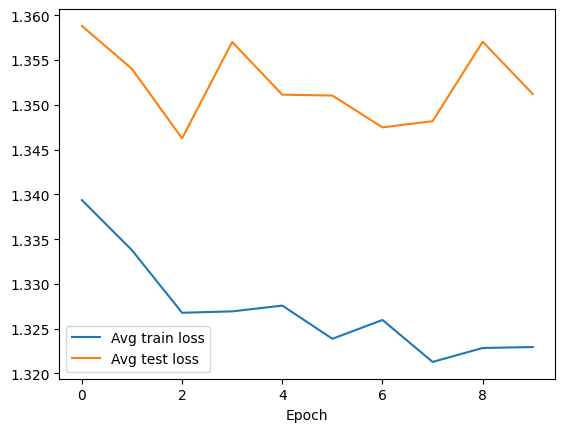

In [69]:
plt.plot(train_loss, label="Avg train loss")
plt.plot(test_loss, label="Avg test loss")
plt.legend()
plt.xlabel("Epoch")
plt.show()